In [1]:
import json
import os

depth = 3
directory_path = f'./airflow/cleaned_data_{depth}'
data = []

for file in os.scandir(directory_path):
    try:
        with open(file.path, 'r') as f: 
            data.extend(json.load(f))

    except Exception as e:
        print(f"Error reading {file.name}: {e}")

In [2]:
og_len = len(data)
og_len

387528

In [3]:
import pandas as pd

data = pd.DataFrame(data)
data = data.sort_values(by='layer', ascending=True)
data


,title,sub_title,text,category,layer
387527,Young subgroup,None,"Inmathematics, theYoung subgroupsof thesymmetr...",Combinatorics,1
154432,Projective plane,Finite projective planes,It can be shown that a projective plane has th...,Algebraic geometry,1
154431,Projective plane,Correlations,Adualityis a map from a projective planeto its...,Algebraic geometry,1
154430,Projective plane,Plane duality,A projective plane is defined axiomatically as...,Algebraic geometry,1
154429,Projective plane,Homography,Ahomography(orprojective transformation) of PG...,Algebraic geometry,1
...,...,...,...,...,...
197179,Futures techniques,Introduction,Futures techniquesused in the multi-disciplina...,Analysis,3
197180,Futures techniques,Delphi method,The Delphi method is a popular technique used ...,Analysis,3
197181,Futures techniques,Causal layered analysis (CLA),"This method, developed bySohail Inayatullah, i...",Analysis,3
197151,Futures studies,Branching trends,"Very often, trends relate to one another the s...",Analysis,3


In [4]:
data = data.drop_duplicates(subset=['text', 'sub_title'])
print(f'{len(data)/og_len:.2%} of df remained')

64.14% of df remained


In [5]:
data['length'] = data['text'].apply(lambda x: len(x.split()))
data.describe(include='all')

/tmp/ipykernel_27625/1579233866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length'] = data['text'].apply(lambda x: len(x.split()))


,title,sub_title,text,category,layer,length
count,248560,236222,248560,248560,248560,248560.000000
unique,45624,122944,247970,30,3,NaN
top,List of fellows of the American Statistical As...,Introduction,*,Applied mathematics,3,NaN
freq,108,33243,87,64166,134604,NaN
mean,NaN,NaN,NaN,NaN,NaN,162.247083
std,NaN,NaN,NaN,NaN,NaN,215.977352
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,59.000000
50%,NaN,NaN,NaN,NaN,NaN,115.000000
75%,NaN,NaN,NaN,NaN,NaN,204.000000


In [6]:
percentiles = data['length'].quantile([0.5, 0.9, 0.95, 0.99])
percentiles

0.50    115.0
0.90    334.0
0.95    449.0
0.99    793.0
Name: length, dtype: float64

In [7]:
data = data[data['length'] <= percentiles[0.99]]
print(f'{len(data)/og_len:.2%} of df remained')
data.describe(include='all')

63.50% of df remained


,title,sub_title,text,category,layer,length
count,246082,233744,246082,246082,246082,246082.000000
unique,45560,121548,245492,30,3,NaN
top,List of fellows of the American Statistical As...,Introduction,*,Applied mathematics,3,NaN
freq,108,33147,87,63507,133100,NaN
mean,NaN,NaN,NaN,NaN,NaN,150.355357
std,NaN,NaN,NaN,NaN,NaN,129.602783
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,59.000000
50%,NaN,NaN,NaN,NaN,NaN,114.000000
75%,NaN,NaN,NaN,NaN,NaN,200.000000


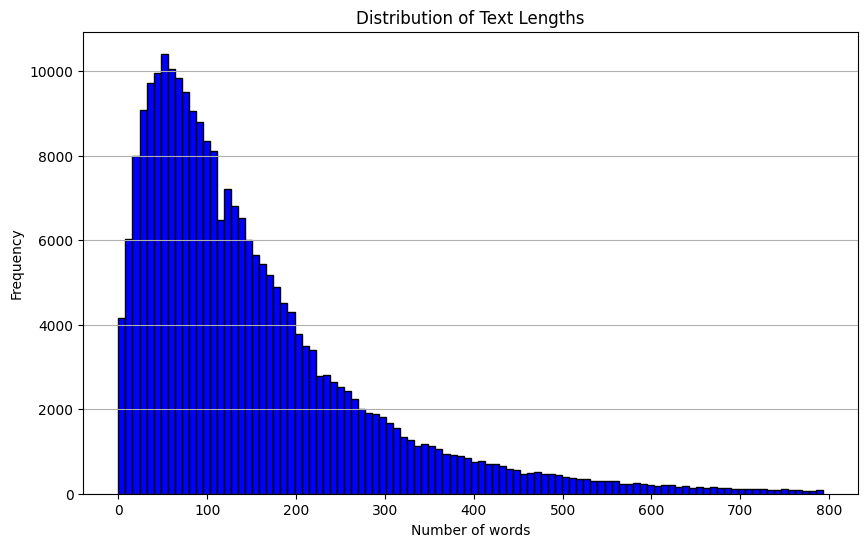

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(data['length'], bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [9]:
import math

def chunk(row):
    chunk_size = 250
    overlap_size = 100
    added_size  = chunk_size - overlap_size
    if row['length'] <= chunk_size:
        yield {'title': row['title'], 'sub_title': row['sub_title'],
                'text': row['text'], 'category': row['category'],
                'layer': row['layer'], 'length': row['length']}
    else:
        text = row['text'].split()
        text_len = len(text)
        for i in range(math.ceil((row['length']-chunk_size)/added_size) + 1):
            yield {'title': row['title'], 'sub_title': row['sub_title'],
                   'text': ' '.join(text[(i*added_size) : min((chunk_size+(i*added_size)), text_len)]),
                   'category': row['category'], 'layer': row['layer'],
                   'length': (min((chunk_size+(i*added_size)), text_len) - (i*added_size))}

In [10]:
# Apply chunking to each row and flatten results
chunked = data.apply(lambda row: list(chunk(row)), axis=1)

# Flatten list of lists into one DataFrame
data = pd.DataFrame([row for sublist in chunked for row in sublist])

In [11]:
data = data[data['length'] >= 20]
data.describe(include='all')

,title,sub_title,text,category,layer,length
count,293311,282493,293311,293311,293311,293311.000000
unique,44011,116225,293280,30,3,NaN
top,Constructive set theory,Introduction,Image;Special fields:This type exists only ove...,Applied mathematics,3,NaN
freq,131,36648,4,76927,159698,NaN
mean,NaN,NaN,NaN,NaN,NaN,146.513738
std,NaN,NaN,NaN,NaN,NaN,75.971197
min,NaN,NaN,NaN,NaN,NaN,20.000000
25%,NaN,NaN,NaN,NaN,NaN,80.000000
50%,NaN,NaN,NaN,NaN,NaN,139.000000
75%,NaN,NaN,NaN,NaN,NaN,227.000000


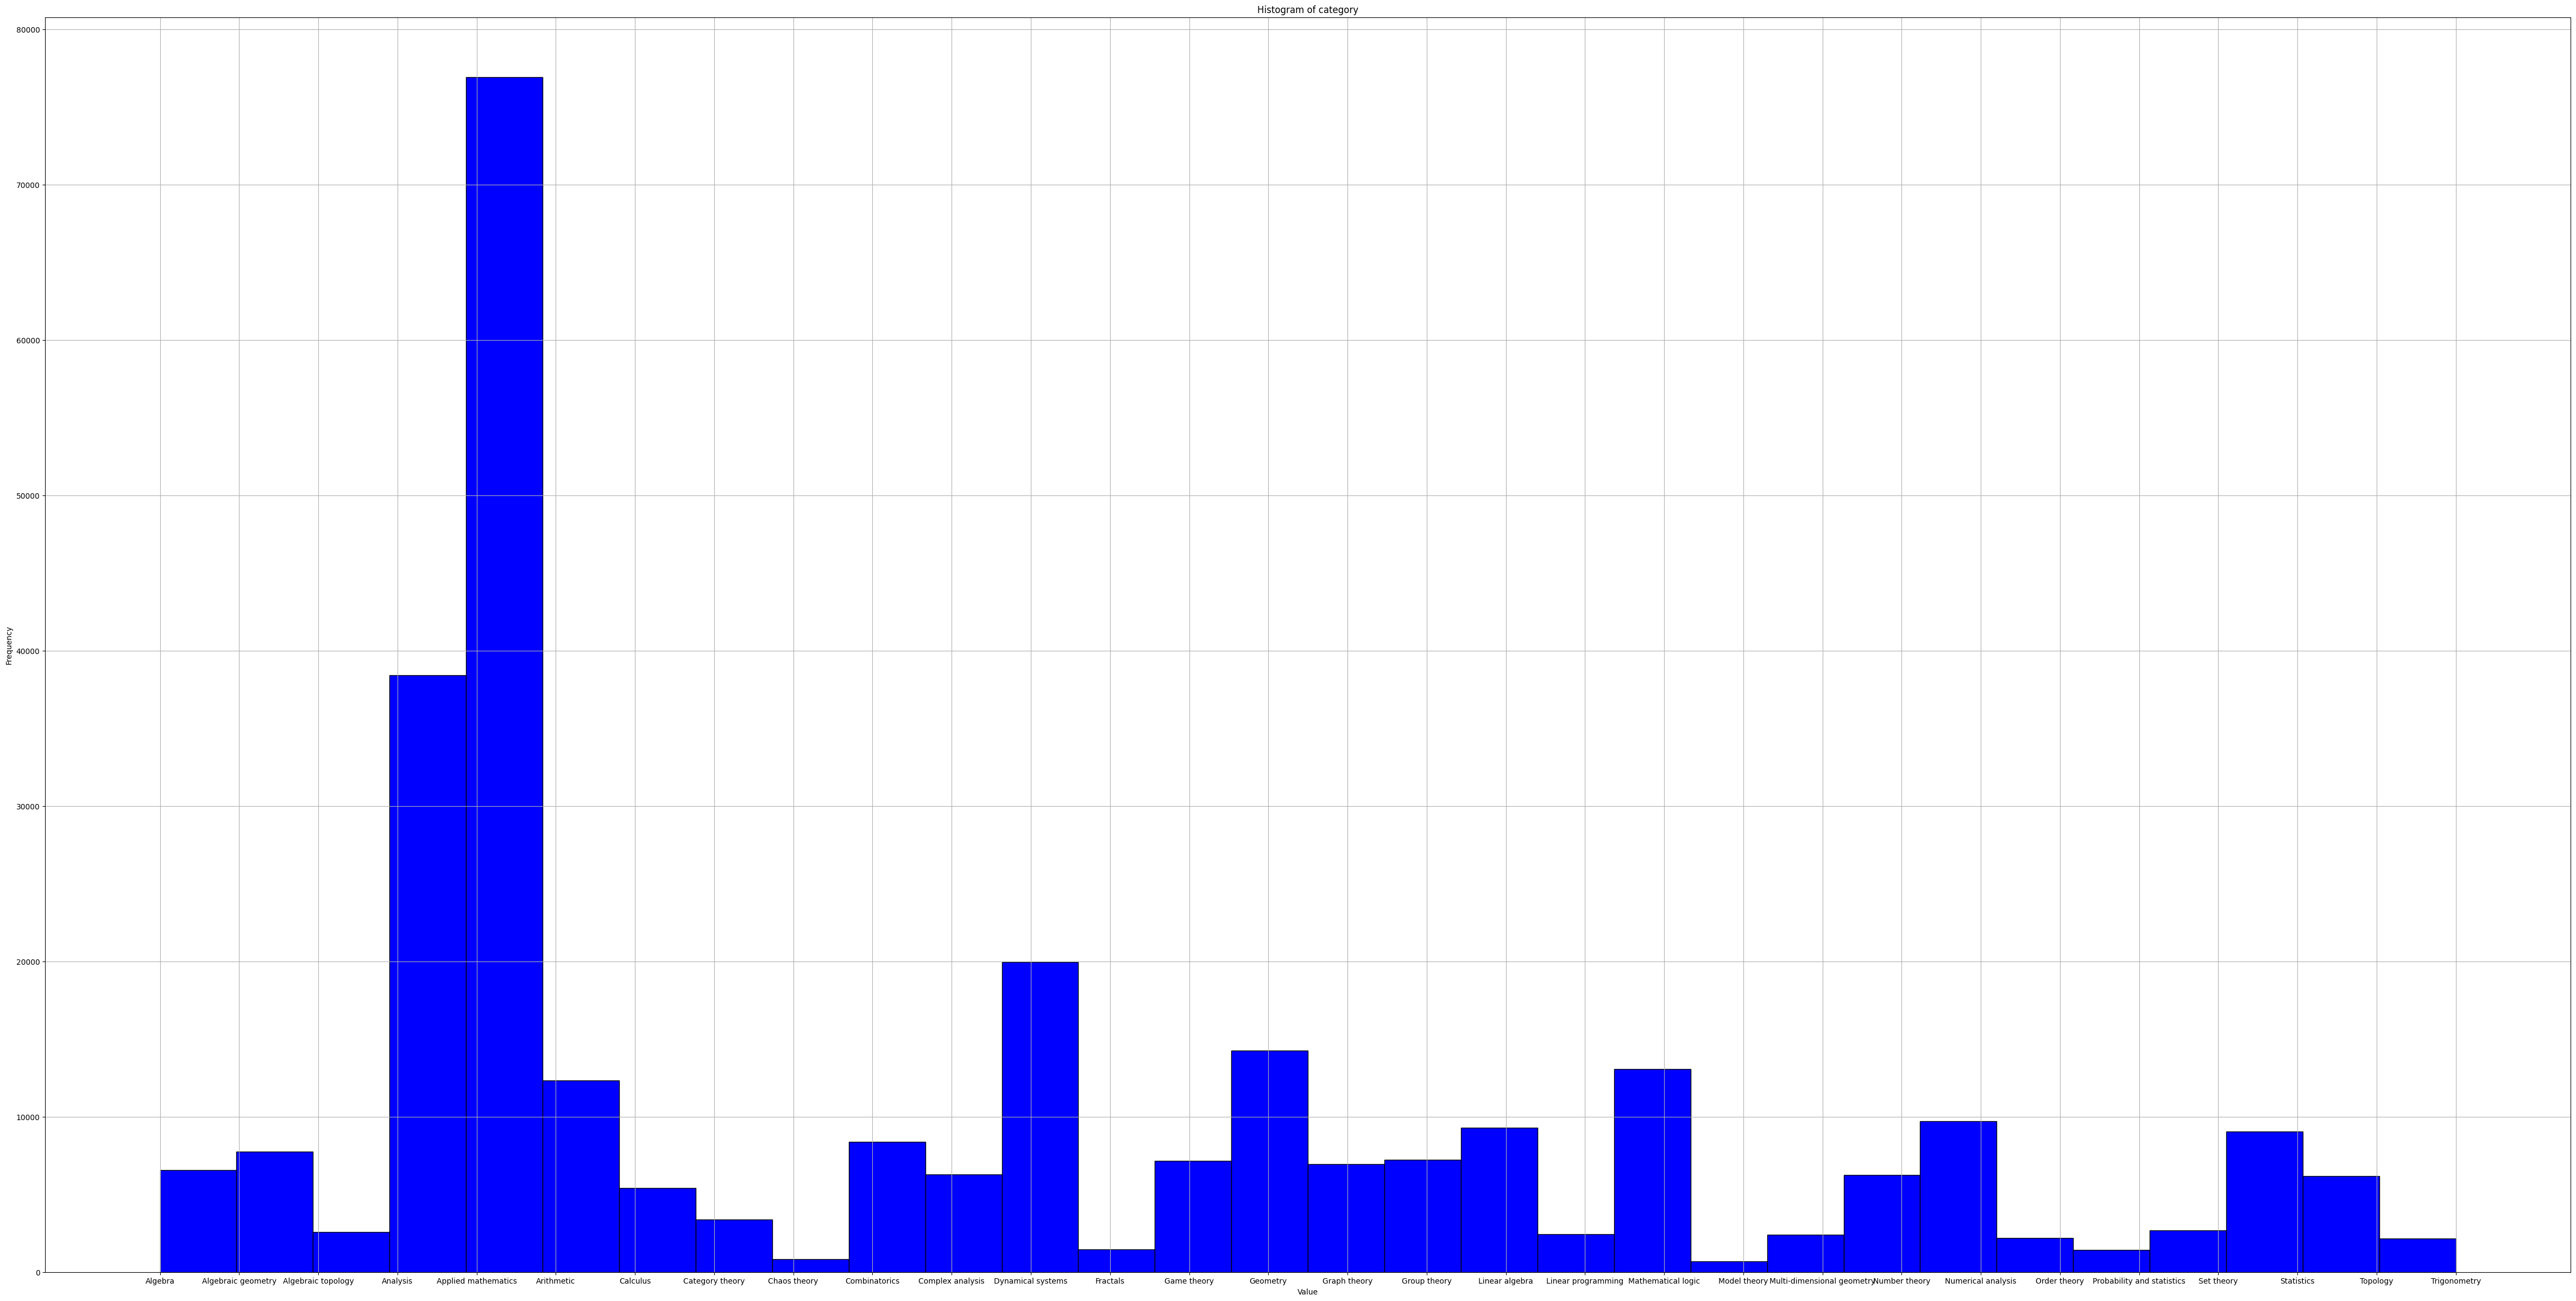

In [12]:
plt.figure(figsize=(60,30))

data.sort_values(by='category')['category'].hist(bins=len(data['category'].unique()), color='blue', edgecolor='black')
plt.title('Histogram of category')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

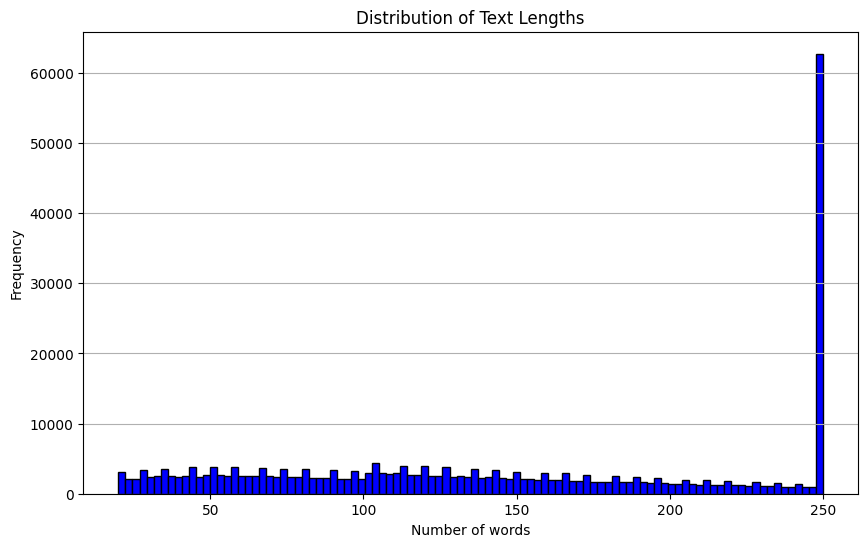

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(data['length'], bins=100, color='blue', edgecolor='black')

plt.title('Distribution of Text Lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

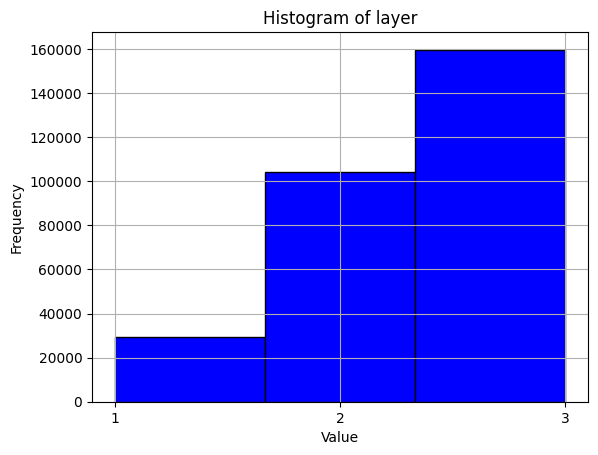

In [14]:
data.sort_values(by='layer')['layer'].hist(bins=len(data['layer'].unique()), color='blue', edgecolor='black')
plt.title('Histogram of layer')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [15]:
rag_df = data[data['layer'] == f'{depth}'] 
fine_tune_df = data[data['layer'] != f'{depth}']

In [16]:
fine_tune_df.describe(include='all')

,title,sub_title,text,category,layer,length
count,133613,128605,133613,133613,133613,133613.000000
unique,19956,56343,133602,30,2,NaN
top,Constructive set theory,Introduction,Image;Special fields:This type exists only ove...,Applied mathematics,2,NaN
freq,131,16331,4,18820,104393,NaN
mean,NaN,NaN,NaN,NaN,NaN,145.066947
std,NaN,NaN,NaN,NaN,NaN,75.624765
min,NaN,NaN,NaN,NaN,NaN,20.000000
25%,NaN,NaN,NaN,NaN,NaN,79.000000
50%,NaN,NaN,NaN,NaN,NaN,137.000000
75%,NaN,NaN,NaN,NaN,NaN,223.000000


In [17]:
rag_df.describe(include='all')

,title,sub_title,text,category,layer,length
count,159698,153888,159698,159698,159698,159698.000000
unique,24055,65629,159680,29,1,NaN
top,Royal Commission on Animal Magnetism,Introduction,The image linked here is claimed to be used un...,Applied mathematics,3,NaN
freq,118,20317,3,58107,159698,NaN
mean,NaN,NaN,NaN,NaN,NaN,147.724211
std,NaN,NaN,NaN,NaN,NaN,76.238978
min,NaN,NaN,NaN,NaN,NaN,20.000000
25%,NaN,NaN,NaN,NaN,NaN,81.000000
50%,NaN,NaN,NaN,NaN,NaN,141.000000
75%,NaN,NaN,NaN,NaN,NaN,230.000000


In [18]:
from sklearn.model_selection import train_test_split

fine_tune_df['stratify'] = fine_tune_df['category'].astype(str) + fine_tune_df['layer'].astype(str)

train_df, _ = train_test_split(fine_tune_df, test_size=0.4, stratify=fine_tune_df[['stratify']], random_state=42)
valid_df, test_df = train_test_split(_, test_size=0.5, stratify=_[['stratify']], random_state=42)


/tmp/ipykernel_27625/3379616835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fine_tune_df['stratify'] = fine_tune_df['category'].astype(str) + fine_tune_df['layer'].astype(str)


In [19]:
for df in [rag_df, train_df, valid_df, test_df]:
    df.drop(columns=['length', 'layer'], inplace=True)

for df in [train_df, valid_df, test_df]:
    df.drop(columns=['stratify'], inplace=True)

/tmp/ipykernel_27625/2808069441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['length', 'layer'], inplace=True)


In [22]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
valid_ds = Dataset.from_pandas(valid_df, preserve_index=False)
test_ds = Dataset.from_pandas(test_df, preserve_index=False)
rag_ds = Dataset.from_pandas(rag_df, preserve_index=False)

ds = DatasetDict({
    'train': train_ds,
    'valid': valid_ds,
    'test': test_ds,
    'rag': rag_ds
})

In [23]:
ds

DatasetDict({
    train: Dataset({
        features: ['title', 'sub_title', 'text', 'category'],
        num_rows: 80167
    })
    valid: Dataset({
        features: ['title', 'sub_title', 'text', 'category'],
        num_rows: 26723
    })
    test: Dataset({
        features: ['title', 'sub_title', 'text', 'category'],
        num_rows: 26723
    })
    rag: Dataset({
        features: ['title', 'sub_title', 'text', 'category'],
        num_rows: 159698
    })
})

In [24]:
from huggingface_hub import login

login()

In [25]:
repo_id = "noor-zalouk/wiki-math-articles"
ds.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/81 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|          |  525kB / 52.7MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/27 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   3%|2         |  525kB / 17.5MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/27 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   3%|3         |  525kB / 17.5MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/160 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         | 1.05MB / 84.5MB            

CommitInfo(commit_url='https://huggingface.co/datasets/noor-zalouk/wiki-math-articles/commit/0f864515f39466cbddddb83145d89bfa147634aa', commit_message='Upload dataset', commit_description='', oid='0f864515f39466cbddddb83145d89bfa147634aa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/noor-zalouk/wiki-math-articles', endpoint='https://huggingface.co', repo_type='dataset', repo_id='noor-zalouk/wiki-math-articles'), pr_revision=None, pr_num=None)